# ARIMA (SARIMA)

Primeiro aplicamos o S(ARIMA) nos dados históricos referente à venda de interruptores, pulsadores e tomadas.

In [15]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

import pickle

In [2]:
vendas = pd.read_csv('datasets/serie_historica_2014_2020.csv') # Dados vendas interruptores, tomadas e pulsadores - ADP255.
# cria a coluna de data no formato Datetime
vendas = vendas.rename(columns={'ano':'year','mes':'month'})
vendas['day'] = 1
vendas['date'] = pd.to_datetime(vendas[['year','month','day']])
# seta a coluna de data como index
vendas = vendas.set_index('date')

vendas # Base de dados para o trabalho.

,year,month,interruptores,pulsadores,tomadas,total,day
date,,,,,,,
2014-01-01,2014,1,5109625,149613,8168659,13427897,1
2014-02-01,2014,2,5235998,141128,8774994,14152120,1
2014-03-01,2014,3,5100680,144853,8465237,13710770,1
2014-04-01,2014,4,4695875,132094,7774926,12602895,1
2014-05-01,2014,5,5563254,156946,8883242,14603442,1
...,...,...,...,...,...,...,...
2020-08-01,2020,8,11713475,210921,22059317,33983713,1
2020-09-01,2020,9,10635364,229234,21341217,32205815,1
2020-10-01,2020,10,11688385,213752,21847140,33749277,1


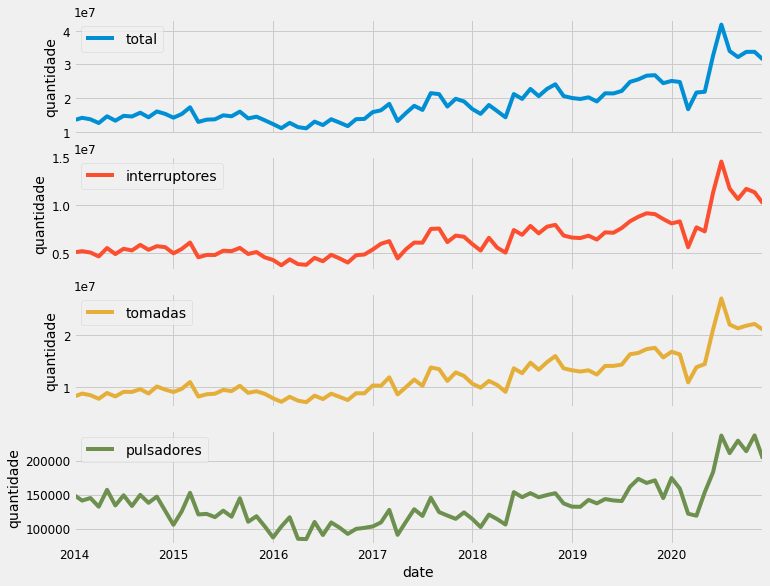

In [3]:
# plota o total de vendas e por tipo de produto
cols_plot = ['total', 'interruptores', 'tomadas', 'pulsadores']
axes = vendas[cols_plot].plot( figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('quantidade')

É possível observar que os três produtos possuem um padrão de venda semelhante. Também observa-se uma sazonalidade nas vendas, onde após o início do ano há uma declínio seguido de um significante aumento nas vendas.

<AxesSubplot:xlabel='date'>

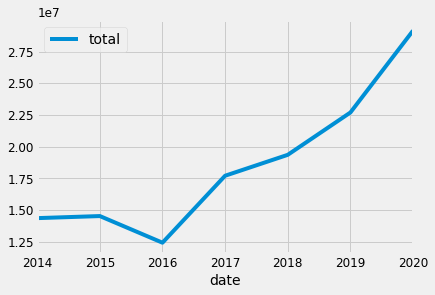

In [4]:
# venda total (média anual)
data_columns = ['total']
vendas_media_anual = vendas[data_columns].resample('A').mean()
vendas_media_anual.plot()

Considerando apenas a média anual das vendas totais, percebe-se apenas no ano de 2015 um declínio na quantidade. Após 2016, a quantidade média do total de produtos apresenta crescimento constante.

<AxesSubplot:xlabel='month', ylabel='total'>

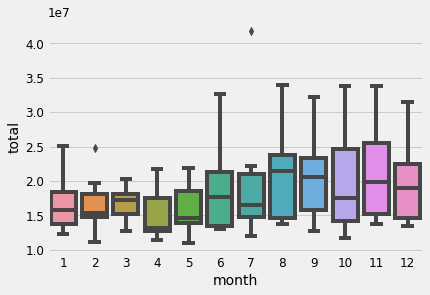

In [5]:
# sazonalidade (agrupa por meses)
sns.boxplot(data=vendas, x='month', y='total')

Aqui é possível verificar a sazonalidade na quantidade total, com declínio nas vendas no mês de março, seguido de aumento até o final do ano.

In [6]:
# apenas para marcar a FREQ=MS, "calcula" a média mas não altera os valores
# pois continua sendo frequencia mensal
y = vendas['total'].resample('MS').mean()

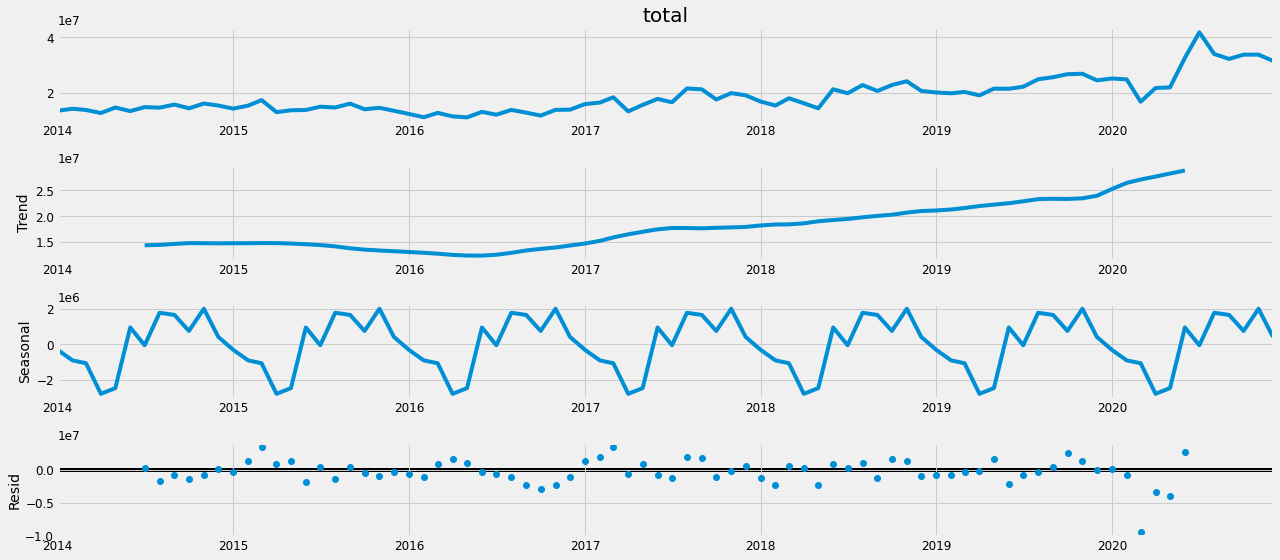

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()


time-series decomposition: that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

In [8]:
# Grid-Search para achar os parâmetros ótimos para o modelo ARIMA

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        except:
            continue
results = mod.fit()
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1870.1591523536733


In [9]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3444      0.224      1.536      0.125      -0.095       0.784
ma.L1         -0.7764      0.210     -3.705      0.000      -1.187      -0.366
ar.S.L12      -0.4707      0.392     -1.201      0.230      -1.239       0.297
ma.S.L12      -0.1674      0.396     -0.422      0.673      -0.944       0.610
sigma2      9.851e+12   6.98e-14   1.41e+26      0.000    9.85e+12    9.85e+12


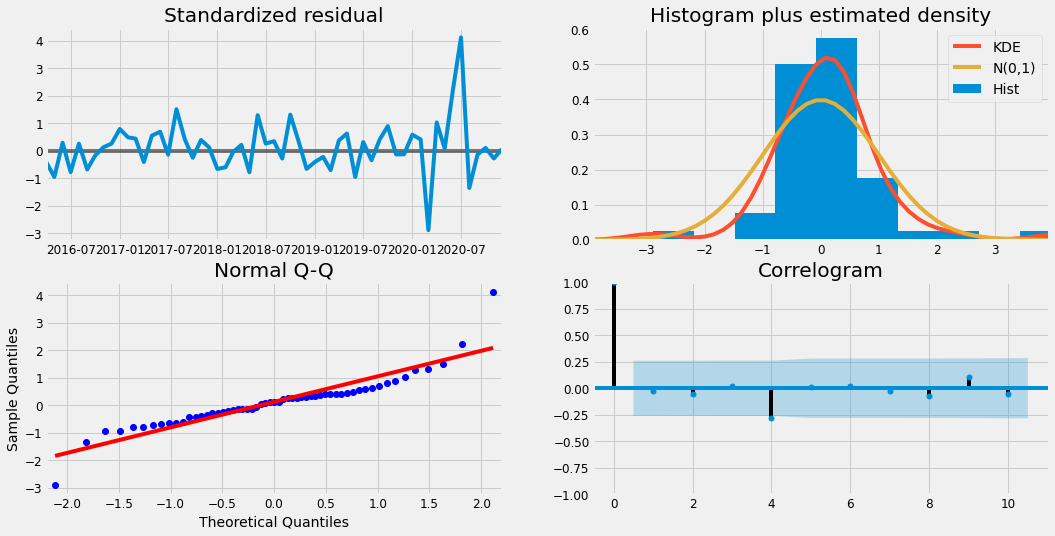

In [ ]:
# verifica se alguma anomalia nos dados
results.plot_diagnostics(figsize=(16, 8))
plt.show()

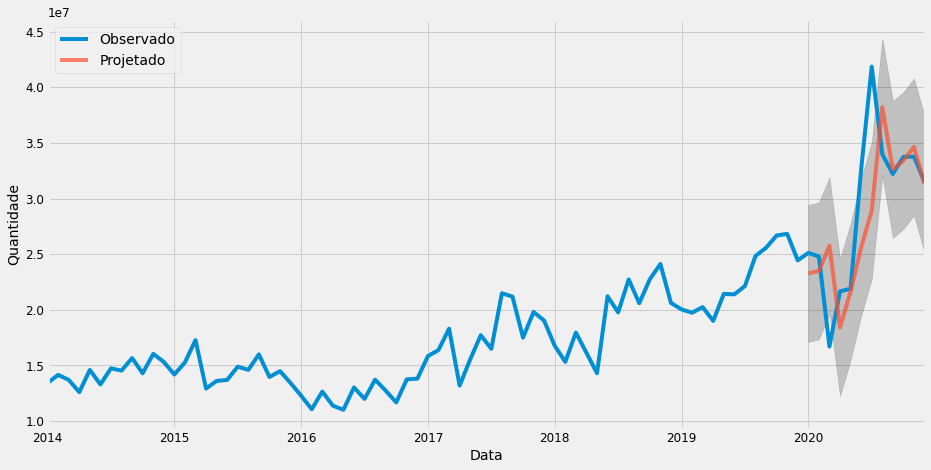

In [10]:
# Cereja do Bolo: aqui podemos comparar a previsão da demanda para o ano de 2020.
# em AZUL são os dados reais da demanda
# em LARANJA sao os dados projetados pelo modelo
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y.plot(label='Observado')
pred.predicted_mean.plot(ax=ax, label='Projetado', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Quantidade')
plt.legend()
plt.show()

In [11]:
y_forecasted = pred.predicted_mean
y_truth = y['2020-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Erro Quadrático Médio da projeção {}'.format(round(mse, 2)))
print('Raiz do Erro Quadrático Médio da projeção {}'.format(round(np.sqrt(mse), 2)))

Erro Quadrático Médio da projeção 27765454118830.02
Raiz do Erro Quadrático Médio da projeção 5269293.51


Raiz do MSE = 5.269.293 Sendo que os totais de venda variam de 41.851.313 a 11.024.039

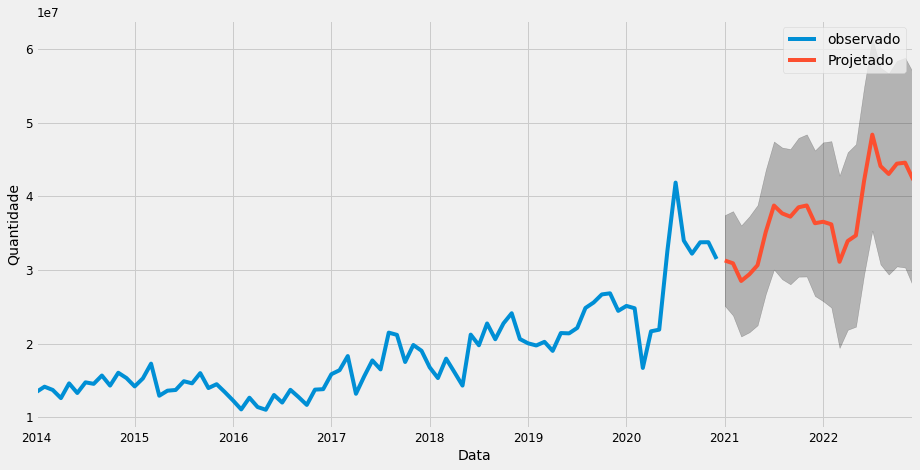

In [12]:
# Projetando a demanda para 2021 e 2022. Será?! kkk

pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observado', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Projetado')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Quantidade')
plt.legend()
plt.show()